In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from google.colab import drive
import os
import cv2
import random


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Paths
base_dir = "/content/drive/MyDrive/breast_cancer_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")



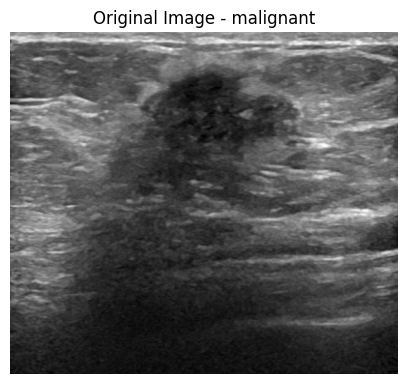

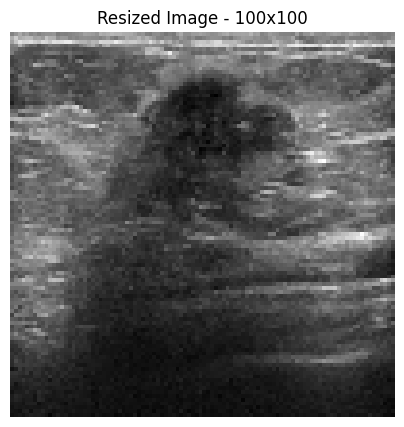

Found 1203 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 366 images belonging to 2 classes.


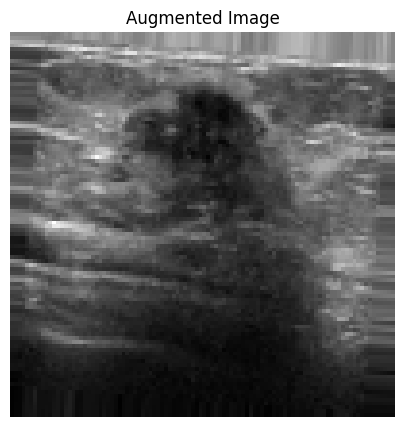

Training set: {'benign': 820, 'malignant': 383}
Validation set: {'benign': 247, 'malignant': 117}
Test set: {'benign': 250, 'malignant': 116}


In [8]:
# Hyperparameters
img_size = 100
batch_size = 32
learning_rate = 0.0001


category = random.choice(os.listdir(train_dir))
category_path = os.path.join(train_dir, category)

# Pick a random image from that category
img_name = random.choice(os.listdir(category_path))
img_path = os.path.join(category_path, img_name)

# 1️⃣ Original image
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(5,5))
plt.imshow(original_img, cmap='gray')
plt.title(f"Original Image - {category}")
plt.axis('off')
plt.show()
# 2️⃣ Resized image
resized_img = cv2.resize(original_img, (img_size, img_size))
plt.figure(figsize=(5,5))
plt.imshow(resized_img, cmap='gray')
plt.title(f"Resized Image - {img_size}x{img_size}")
plt.axis('off')
plt.show()
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation & Test generator (only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
resized_img_rgb = resized_img_rgb.reshape((1, img_size, img_size, 3))

aug_iter = train_datagen.flow(resized_img_rgb, batch_size=1)
augmented_img = next(aug_iter)[0].astype('float32')
augmented_img_gray = cv2.cvtColor((augmented_img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(5,5))
plt.imshow(augmented_img_gray, cmap='gray')
plt.title("Augmented Image")
plt.axis('off')
plt.show()

def count_images(generator):
    counts = {}
    for class_label, index in generator.class_indices.items():
        counts[class_label] = list(generator.classes).count(index)
    return counts

print("Training set:", count_images(train_generator))
print("Validation set:", count_images(val_generator))
print("Test set:", count_images(test_generator))

In [9]:
x_batch, y_batch = next(train_generator)
print(x_batch.shape)

(32, 100, 100, 1)


In [22]:
#========================
#       model_1
#========================
model_1 = Sequential()

# Conv Block 1
model_1.add(Conv2D(32, (3,3), input_shape=(img_size,img_size,1)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 2
model_1.add(Conv2D(64, (3,3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 3
model_1.add(Conv2D(128, (3,3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.3))

# Fully Connected Layers
model_1.add(Flatten())
model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# Compile the model
model_1.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
history = model_1.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - accuracy: 0.6959 - loss: 0.5873 - val_accuracy: 0.7170 - val_loss: 0.5544
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.7054 - loss: 0.5826 - val_accuracy: 0.7115 - val_loss: 0.5521
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - accuracy: 0.7169 - loss: 0.5626 - val_accuracy: 0.7198 - val_loss: 0.5473
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.6949 - loss: 0.5666 - val_accuracy: 0.7308 - val_loss: 0.5307
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - accuracy: 0.6933 - loss: 0.5568 - val_accuracy: 0.7088 - val_loss: 0.5540
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.7120 - loss: 0.5549 - val_accuracy: 0.7308 - val_loss: 0.5210
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.6934 - loss: 0.5652 - val_accuracy: 0.7418 - val_loss: 0.5171
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.7041 - loss: 0.5572 - val_accu

In [27]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc = model_1.evaluate(test_generator)
print("✅ Model 1 Test accuracy:", test_acc)


Found 366 images belonging to 2 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9036 - loss: 0.3199
✅ Model 1 Test accuracy: 0.8196721076965332


In [28]:
# ===========================
# Model 2
# ===========================
model_2 = Sequential()

# Conv Block 1
model_2.add(Conv2D(32, (3,3), input_shape=(img_size,img_size,1),
                   kernel_regularizer=regularizers.l2(0.001)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 2
model_2.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.001)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 3
model_2.add(Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(0.001)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.4))  # slightly higher dropout

# Fully Connected Layers
model_2.add(Flatten())
model_2.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Compile model_2
model_2.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,329 (6.60 MB)

 Trainable params: 1,731,329 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_2 = model_2.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.6364 - loss: 1.0382 - val_accuracy: 0.6786 - val_loss: 0.9653
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.6838 - loss: 0.9513 - val_accuracy: 0.6786 - val_loss: 0.9099
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.6742 - loss: 0.8977 - val_accuracy: 0.6786 - val_loss: 0.8575
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.6855 - loss: 0.8464 - val_accuracy: 0.7060 - val_loss: 0.8227
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - accuracy: 0.6944 - loss: 0.8159 - val_accuracy: 0.7143 - val_loss: 0.7842
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.6994 - loss: 0.7929 - val_accuracy: 0.7198 - val_loss: 0.7696
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.7179 - loss: 0.7602 - val_accuracy: 0.7170 - val_loss: 0.7395
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.7214 - loss: 0.7355 - val_accu

In [30]:
test_loss_2, test_acc_2 = model_2.evaluate(test_generator)
print("✅ Model 2 Test accuracy:", test_acc_2)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.9112 - loss: 0.4610
✅ Model 2 Test accuracy: 0.7759562730789185


In [31]:
#============================
# Model_1_1
#============================
model_1_1 = Sequential()

# Conv Block 1
model_1_1.add(Conv2D(32, (3,3), input_shape=(img_size,img_size,1)))
model_1_1.add(Activation('relu'))
model_1_1.add(MaxPooling2D(pool_size=(2,2)))
model_1_1.add(Dropout(0.2))

# Conv Block 2
model_1_1.add(Conv2D(64, (3,3)))
model_1_1.add(Activation('relu'))
model_1_1.add(MaxPooling2D(pool_size=(2,2)))
model_1_1.add(Dropout(0.2))

# Conv Block 3
model_1_1.add(Conv2D(128, (3,3)))
model_1_1.add(Activation('relu'))
model_1_1.add(MaxPooling2D(pool_size=(2,2)))
model_1_1.add(Dropout(0.3))

# Fully Connected Layers
model_1_1.add(Flatten())
model_1_1.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005)))
model_1_1.add(Activation('relu'))
model_1_1.add(Dropout(0.5))
model_1_1.add(Dense(1))
model_1_1.add(Activation('sigmoid'))

# Compile
model_1_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_1_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,329 (6.60 MB)

 Trainable params: 1,731,329 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_3 = model_1_1.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)
test_loss_3, test_acc_3 = model_1_1.evaluate(test_generator)
print("✅ Model_1_1 Test accuracy:", test_acc_3)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.6757 - loss: 0.7868 - val_accuracy: 0.6786 - val_loss: 0.7754
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step - accuracy: 0.6629 - loss: 0.7664 - val_accuracy: 0.6786 - val_loss: 0.7468
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.6855 - loss: 0.7382 - val_accuracy: 0.6841 - val_loss: 0.7178
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.6976 - loss: 0.7015 - val_accuracy: 0.6813 - val_loss: 0.6973
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.6794 - loss: 0.6962 - val_accuracy: 0.6978 - val_loss: 0.6847
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.7096 - loss: 0.6680 - val_accuracy: 0.7198 - val_loss: 0.6630
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.7103 - loss: 0.6590 - val_accuracy: 0.7225 - val_loss: 0.6465
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.6970 - loss: 0.6480 - val_accu